In [255]:
# libs
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
from datetime import datetime
import os
from tqdm import tqdm  # Import the tqdm function to visualize the progress of the loop

# bar plots
import matplotlib.pyplot as plt
import seaborn as sns

# TradingView (Data Load)

In [256]:
# today's date string for file namine automation
# today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
today_date_str = '_2024-02-29.csv'
print(today_date_str)

_2024-03-03.csv


In [257]:
# cocncat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"

# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'trading_view_raw_data/tv_screen_gap-up_2024-03-03.csv'

In [ ]:
# # first 10 rows df
# trading_view_raw_df_testing = trading_view_raw_df.head(10)
# # save to csv
# trading_view_raw_df_testing.to_csv('trading_view_raw_data/tv_screen_gap-up_testing.csv', index=False)
# # make sure data is there at least
# print(len(trading_view_raw_df_testing.index))

# # print test df
# trading_view_raw_df_testing

In [ ]:
# # baseline raw cols from trading view initial filter
# features_raw_all = trading_view_raw_df.columns
# # convert to list
# features_raw_all = features_raw_all.tolist()
# # look at the trading view columns
# print(features_raw_all)

In [ ]:
"""
define function -> add new column and marketCapType based on 'Market capitalization' column

criteria (6 groupings):
200B and above = 'Titans' - 1
10B to 200B = 'Large caps' - 2
2B to 10B = 'Midlers' - 3
300M to 2B = 'Small caps' - 4
300m and below = 'Micro caps' - 5
50m and below = 'Shrimp' - 6

"""

"\ndefine function -> add new column and marketCapType based on 'Market capitalization' column\n\ncriteria (6 groupings):\n200B and above = 'Titans' - 1\n10B to 200B = 'Large caps' - 2\n2B to 10B = 'Midlers' - 3\n300M to 2B = 'Small caps' - 4\n300m and below = 'Micro caps' - 5\n50m and below = 'Shrimp' - 6\n\n"

In [ ]:
def categorize_market_cap(df):
    # Convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    
    # Define the conditions for each market cap category using regular number notation
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    
    # Define the category names corresponding to each condition
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    
    # Use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [ ]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,NVDA,NVIDIA Corporation,NASDAQ,1.977800e+12,USD,791.12,USD,801.39,USD,9.8962,USD,1.250910,1.298160,2399390000,50728898,179607735.0,461364,58011451.2,51690931.63333332,45516882.88888901,2.970006,3.588463,3.702409,791.506667,66.27738449,Electronic Technology,1.41145322,1.7775623,2.3419523,1.7245569,2.811585,4.026721,4.939247,2.708996,1.176995,0.621275,0.465039,0.874821,0.81901796,1.1420741,823.940,USD,823.94,USD,823.94,USD,823.94,USD,823.94,USD,798.98,USD,799.90,USD,799.90,USD,799.90,USD,799.90,USD,799.90,USD,799.90,USD,806.4599,USD,823.940,USD,2058175.67567568,USD,796.50400,797.247813,796.33750,794.409569,800.797432,797.508365,794.219298,797.816379,794.003400,790.190421,Titans
1,GOOGL,Alphabet Inc.,NASDAQ,1.728959e+12,USD,138.46,USD,138.60,USD,0.1400,USD,0.101112,0.101112,5871219472,42132953,166202496.0,94953,33019915.8,32596197.63333334,30260050.71111111,1.818182,2.012854,1.947087,137.906667,23.85103011,Technology Services,1.96453815,1.0654415,1.1459233,1.0442357,4.812695,10.770391,9.098203,5.007036,1.785762,0.893884,0.737224,1.355758,1.28319343,1.03141868,149.440,USD,153.78,USD,153.78,USD,153.78,USD,153.78,USD,138.55,USD,138.55,USD,138.55,USD,138.55,USD,138.55,USD,138.55,USD,138.86,USD,142.4400,USD,149.440,USD,1683033.61059057,USD,138.40780,138.226538,137.73652,137.485662,138.581496,137.835610,137.089724,137.961556,137.385985,136.810414,Titans
2,GOOG,Alphabet Inc.,NASDAQ,1.728959e+12,USD,139.78,USD,140.02,USD,0.0860,USD,0.061525,0.171698,5277727492,35485006,121990700.0,55747,24324943.7,23629939.93333337,22661690.51111112,1.831795,1.956129,1.898754,139.100000,24.07841246,Technology Services,1.93925735,1.0578916,1.1586931,1.0489115,5.096900,9.713935,9.182034,5.078782,1.698367,0.925065,0.790819,1.581214,1.27861898,0.98726868,150.695,USD,155.20,USD,155.20,USD,155.20,USD,155.20,USD,139.83,USD,139.83,USD,139.83,USD,139.83,USD,139.83,USD,139.83,USD,139.95,USD,143.8400,USD,150.695,USD,1683033.61059057,USD,139.68700,139.474375,138.96702,138.684415,139.859144,139.061135,138.263126,139.243460,138.545870,137.848280,Titans
3,BRK.B,Berkshire Hathaway Inc. New,NYSE,8.850193e+11,USD,409.40,USD,410.05,USD,0.2200,USD,0.053737,0.158769,

In [ ]:
# # check for NaNs
# print(trading_view_raw_df.isna().sum())

In [ ]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
# get simple count of NaNs total. should be 0
print(f'NaNs = {tv_df.isna().sum().sum()}')

# if there are no NaNs, print "No NaNs in DataFrame! Success!", else print the NaN count and "There are x NaNs in DataFrame, check your code dumb dumb!"
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")


NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [ ]:
mc_groups = trading_view_raw_df['marketCapType'].value_counts().reset_index()
mc_groups.columns = ['marketCapType', 'count']  # Rename columns for clarity

# Calculate percentage for each market cap type and add it to the DataFrame
mc_groups['percentage'] = (mc_groups['count'] / mc_groups['count'].sum()) * 100

# print total "there are etc."
print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
# Display the enhanced DataFrame
mc_groups

There are still the same 1383 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Small caps,308,22.270427
1,Shrimp,273,19.739696
2,Large caps,272,19.667390
3,Midlers,258,18.655098
4,Micro caps,235,16.992046
5,Titans,26,1.879971
6,Undefined,11,0.795372


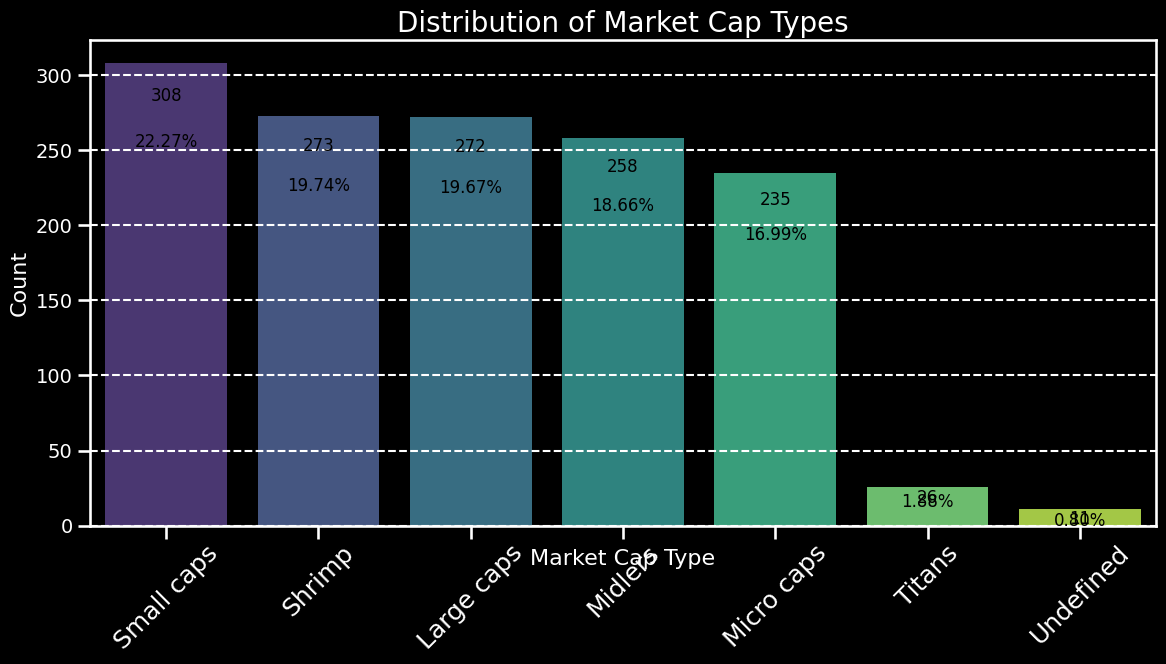

In [ ]:
# Set dark mode for plotting
plt.style.use('dark_background')
sns.set_context('talk')  # Larger fonts and figures

# Create a bar chart
plt.figure(figsize=(12, 7))
barplot = sns.barplot(data=mc_groups, x='marketCapType', y='count', hue='marketCapType', palette='viridis', dodge=False)

# Disable the legend
plt.legend([],[], frameon=False)

# Customize the plot with count and percentage labels inside the bars
for index, row in mc_groups.iterrows():
    # Calculate the position for the count and percentage text to be inside the bar
    height = row['count']
    offset = height * 0.05  # Offset from the top of the bar for better visibility
    
    # Display the count inside the bar at the top
    barplot.text(index, height - offset, f'{row["count"]}', color='black', ha="center", va="top", fontsize=12)
    
    # Display the percentage just below the count, inside the bar
    # Adjust the vertical position slightly below the count
    percentage_offset = height * 0.15  # Adjust this value as needed to fit inside the bar
    barplot.text(index, height - percentage_offset, f'{row["percentage"]:.2f}%', color='black', ha="center", va="top", fontsize=12)

# Add marketCapType labels underneath the bars
for index, row in mc_groups.iterrows():
    barplot.text(index, -10, row['marketCapType'], color='white', ha="center", va="top", rotation=45)

plt.title('Distribution of Market Cap Types', fontsize=20, color='white')
plt.xlabel('Market Cap Type', fontsize=16, color='white')
plt.ylabel('Count', fontsize=16, color='white')
plt.xticks(rotation=45, fontsize=14, color='white')
plt.yticks(fontsize=14, color='white')

# Remove x-axis labels to avoid redundancy
barplot.set_xticklabels([])

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

1372 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
1020,ALAR,Alarum Technologies Ltd.,NASDAQ,1.101028e+08,USD,17.50,USD,18.360,USD,0.860,USD,4.914286,4.914286,5977946.44037,255117,1138701.0,1675,179429.1,178314.36666667,139165.35555556,12.181818,14.314543,11.204283,17.473333,-,Technology Services,1.96489104,1.058953,1.2470315,0.8072395,1.232609,2.846936,1.407548,1.463934,0.802179,0.427254,0.835169,1.544311,1.11536423,1.59854327,18.42,USD,18.42,USD,18.42,USD,18.42,USD,2634.0,USD,17.6900,USD,17.7000,USD,17.9050,USD,17.9050,USD,17.9050,USD,17.9500,USD,18.420,USD,18.4200,USD,18.42,USD,-,-,17.52998,17.518738,17.55598,17.748069,17.770410,17.563245,17.356080,18.007085,17.693995,17.380905,Micro caps
1246,CURO,CURO Group Holdings Corp.,NYSE,9.086120e+06,USD,0.22,USD,0.221,USD,0.008,USD,3.636364,0.454545,17928340.5475,108122,1136359.0,1084,3364525.3,1409767.23333333,523088.92222222,7.727273,11.977385,37.691829,0.225667,-,Finance,0.23105622,2.6230164,1.5618135,2.2244701,0.983244,0.550574,3.722739,5.474314,3.581774,0.601341,0.296603,0.031531,0.26779581,15.82545565,0.91,USD,1.28,USD,1.34,USD,2.92,USD,32.2,USD,0.2297,USD,0.2297,USD,0.2297,USD,0.2297,USD,0.2297,USD,0.2370,USD,0.237,USD,0.2677,USD,0.91,USD,-,-,0.22332,0.223610,0.22412,0.226500,0.232833,0.226004,0.219175,0.239332,0.229120,0.218908,Shrimp
844,SNDL,SNDL Inc.,NASDAQ,3.516615e+08,USD,1.35,USD,1.380,USD,0.010,USD,0.740741,2.222222,258388887.66000003,2254173,7952804.0,35745,2524629.2,2742569.7,2958925.12222222,3.703704,3.638581,4.269415,1.366667,-,Process Industries,2.43838555,1.3367882,0.89912695,3.355417,1.905852,8.039830,5.558897,2.816625,1.117816,0.607918,0.671486,0.810277,0.51764434,0.70917705,1.49,USD,1.71,USD,2.36,USD,2.36,USD,132.2,USD,1.3600,USD,1.3600,USD,1.3600,USD,1.3600,USD,1.3600,USD,1.3700,USD,1.400,USD,1.4300,USD,1.49,USD,209844.2133572,USD,1.35100,1.353125,1.35204,1.352323,1.358444,1.352510,1.346576,1.362013,1.353425,1.344837,Small caps
396,AMR,"Alpha Metallurgical Resources, Inc.",NYSE,4.902197e+09,USD,377.25,USD,380.000,USD,2.750,USD,0.728960,0.728960,10539868.0816,410877,1817473.0,157,288429.3,234264.33333333,279294.96666667,4.185228,8.385397,5.455749,372.916667,7.74529328,Energy Minerals,2.02910262,0.58178

In [ ]:
# show unique values for 'marketCapType'
print(tv_df['marketCapType'].unique())
print()
# get tv_df columns
print(tv_df.columns)

['Titans' 'Large caps' 'Midlers' 'Small caps' 'Micro caps' 'Shrimp']

Index(['Symbol', 'Description', 'Exchange', 'Market capitalization',
       'Market capitalization - Currency', 'Price', 'Price - Currency',
       'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change',
       'Pre-market Change - Currency', 'Pre-market Change %',
       'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day',
       'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days',
       'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day',
       'Volatility 1 week', 'Volatility 1 month',
       'Volume Weighted Average Price 1 day', 'Price to earnings ratio',
       'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years',
       'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes',
       'Relative Volume 15 minutes', 'Relative Volume 30 minutes',
       'Relative Volume 1 hour', 'Relative Volume 2 hours',
       'Relative Volume 

In [ ]:
# drop undefined
tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

mc_groups2 = tv_df['marketCapType'].value_counts().reset_index()
mc_groups2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# calculate percentage for each market cap type and add it to the DataFrame
mc_groups2['percentage'] = (mc_groups2['count'] / mc_groups2['count'].sum()) * 100

mc_groups2
print(mc_groups2)


  marketCapType  count  percentage
0    Small caps    308   22.448980
1        Shrimp    273   19.897959
2    Large caps    272   19.825073
3       Midlers    258   18.804665
4    Micro caps    235   17.128280
5        Titans     26    1.895044


In [ ]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
        "relative_volume_threshold": 1.2,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
        "pre_market_vmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
        "relative_volume_threshold": 1.3,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
        "pre_market_vmap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
    },
    "Midlers": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .02,
        "pre_market_vmap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .03,
        "pre_market_vmap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .04,
        "pre_market_vmap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .05,
        "pre_market_vmap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    # Convert 'Relative Volume at Time' to float
    df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vmap_drawdown_threshold):
    """
    Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
    """
    df_filtered = df.copy()
    df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
    df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
    # Calculate the acceptable minimum price based on the VWAP drawdown threshold
    df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vmap_drawdown_threshold)
    
    # Apply the filter
    df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
    return df_filtered.drop(columns=['Min Price from VWAP'])

"""SPECIAL FILTERS"""
def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    # Ensure data types are correct; convert to numeric if necessary
    df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    filtered_df = df[
        (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
        (df['Volatility 1 day'] >= df['Volatility 1 month'])]
    return filtered_df

# def filter_by_price_above_vwap(df):
#     """Filter stocks where the price is greater than the VWAP 1 day."""
#     # Ensure data types are correct; convert to numeric if necessary
#     df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
#     df['Volume Weighted Average Price 1 day'] = pd.to_numeric(df['Volume Weighted Average Price 1 day'], errors='coerce')
    
#     # Apply the filter
#     filtered_df = df[df['Price'] > df['Volume Weighted Average Price 1 day']]
#     return filtered_df

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vmap_drawdown_threshold = config.get("pre_market_vmap_drawdown_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
    # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vmap_drawdown_threshold)
  
    # 3c. Return the filtered DataFrame
    return filtered_df

In [ ]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')
print()
print(tv_L2_df.columns)

# filter in descending order by market cap and then by pre-market change percentage
tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# reset index and drop
tv_L2_df = tv_L2_df.reset_index(drop=True)
# display head
display(tv_L2_df.head(20))

Original DataFrame length: 1372
Number of rows removed: 1353
NEW DataFrame length: 19

Index(['Symbol', 'Description', 'Exchange', 'Market capitalization',
       'Market capitalization - Currency', 'Price', 'Price - Currency',
       'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change',
       'Pre-market Change - Currency', 'Pre-market Change %',
       'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day',
       'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days',
       'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day',
       'Volatility 1 week', 'Volatility 1 month',
       'Volume Weighted Average Price 1 day', 'Price to earnings ratio',
       'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years',
       'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes',
       'Relative Volume 15 minutes', 'Relative Volume 30 minutes',
       'Relative Volume 1 hour', 'Relative Volume 2 hours',
       

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,IOT,Samsara Inc.,NYSE,1.866931e+10,USD,34.55,USD,35.3000,USD,0.7700,USD,2.228654,2.170767,1.668519e+08,14216798,21731642.0,30943,3739490.7,3251816.46666667,3255871.2,6.367656,3.522040,4.655878,34.446767,-,Technology Services,5.414875,2.4634516,1.5505408,1.5505408,2.190470,6.354843,3.777299,2.499319,1.611013,1.139663,1.900524,5.568086,1.67508962,1.01985459,36.78,USD,36.9100,USD,36.9100,USD,36.9100,USD,36.9100,USD,34.7900,USD,34.790,USD,34.950,USD,34.950,USD,34.950,USD,35.340,USD,35.3400,USD,35.3400,USD,36.780,USD,287972.19770521,USD,34.60200,34.651875,34.72400,34.719615,34.931478,34.721050,34.510622,35.078616,34.789485,34.500354,Large caps
1,ENPH,"Enphase Energy, Inc.",NASDAQ,1.724279e+10,USD,127.01,USD,127.3100,USD,1.2868,USD,1.013149,0.236202,1.303949e+08,5269916,13455419.0,9368,3777878.0,4943712.83333333,5428212.21111111,8.579786,4.470947,5.417349,126.583333,41.43071503,Electronic Technology,3.190855,2.1384084,1.7212793,1.4732305,3.175097,3.903653,3.623801,2.684449,1.076629,0.707580,0.864475,1.441230,0.60217879,1.16811257,138.21,USD,139.6500,USD,139.6500,USD,231.4200,USD,339.9200,USD,127.7000,USD,127.700,USD,127.700,USD,127.700,USD,127.700,USD,128.550,USD,129.6600,USD,129.6600,USD,138.210,USD,725621.15932848,USD,127.32700,127.253750,127.10200,127.185146,127.498496,127.122750,126.747004,127.802871,127.083845,126.364819,Large caps
2,SWKS,"Skyworks Solutions, Inc.",NASDAQ,1.681090e+10,USD,104.92,USD,105.6000,USD,0.4100,USD,0.390774,0.648113,1.596461e+08,3277136,7419115.0,401,1748028.0,2176665.7,1924644.85555556,3.407984,1.817765,2.157224,104.313333,18.59789063,Electronic Technology,4.091956,1.3352287,1.4029175,1.3714725,3.461283,11.399371,13.832327,5.977204,2.516094,1.717168,1.423971,2.055484,0.83393457,1.05171617,107.69,USD,115.1200,USD,115.1200,USD,118.4175,USD,204.0000,USD,105.2400,USD,105.240,USD,105.240,USD,105.240,USD,105.240,USD,105.320,USD,105.3200,USD,105.3200,USD,107.515,USD,489476.92307692,USD,105.04800,105.028750,104.81900,104.780000,105.157200,104.865500,104.573800,104.963898,104.753250,104.542602,Large caps
3,ALB,Albemarle Corporation,NYSE,1.618400e+10,USD,137.85,USD,139.9900,USD,2.6600,USD,1.929634,1.5524

In [ ]:
# create a breakdown of the market cap types
mc_groups3 = tv_L2_df['marketCapType'].value_counts().reset_index()
mc_groups3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage for each market cap type and add it to the DataFrame
mc_groups3['percentage'] = (mc_groups3['count'] / mc_groups3['count'].sum()) * 100
# Display the enhanced DataFrame
print(mc_groups3)

  marketCapType  count  percentage
0    Large caps     11   57.894737
1       Midlers      5   26.315789
2    Small caps      1    5.263158
3    Micro caps      1    5.263158
4        Shrimp      1    5.263158


In [ ]:
print(tv_L2_df.columns)
print(len(tv_L2_df.columns))

Index(['Symbol', 'Description', 'Exchange', 'Market capitalization',
       'Market capitalization - Currency', 'Price', 'Price - Currency',
       'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change',
       'Pre-market Change - Currency', 'Pre-market Change %',
       'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day',
       'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days',
       'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day',
       'Volatility 1 week', 'Volatility 1 month',
       'Volume Weighted Average Price 1 day', 'Price to earnings ratio',
       'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years',
       'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes',
       'Relative Volume 15 minutes', 'Relative Volume 30 minutes',
       'Relative Volume 1 hour', 'Relative Volume 2 hours',
       'Relative Volume 4 hours', 'Relative Volume 1 day',
       'Relative Volume 1 week', 'R

In [ ]:
# slice of first 12 columns
tv_L2_df.iloc[:, :12]

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %
0,IOT,Samsara Inc.,NYSE,1.866931e+10,USD,34.55,USD,35.3000,USD,0.7700,USD,2.228654
1,ENPH,"Enphase Energy, Inc.",NASDAQ,1.724279e+10,USD,127.01,USD,127.3100,USD,1.2868,USD,1.013149
2,SWKS,"Skyworks Solutions, Inc.",NASDAQ,1.681090e+10,USD,104.92,USD,105.6000,USD,0.4100,USD,0.390774
3,ALB,Albemarle Corporation,NYSE,1.618400e+10,USD,137.85,USD,139.9900,USD,2.6600,USD,1.929634
4,GDDY,GoDaddy Inc.,NYSE,1.610471e+10,USD,114.15,USD,115.0000,USD,0.8500,USD,0.744634
5,TER,"Teradyne, Inc.",NASDAQ,1.585762e+10,USD,103.59,USD,104.9400,USD,1.3400,USD,1.293561
6,CF,"CF Industries Holdings, Inc.",NYSE,1.520263e+10,USD,80.72,USD,80.9900,USD,0.2700,USD,0.334490
7,EME,"EMCOR Group, Inc.",NYSE,1.475580e+10,USD,313.52,USD,315.7500,USD,2.4800,USD,0.791018
8,RYAN,"Ryan Specialty Holdings, Inc.",NYSE,1.361463e+10,USD,52.38,USD,52.4000,USD,0.0200,USD,0.038183
9,SQM,Sociedad Quimica y Minera S.A.,NYSE,1.355305e+10,USD,49.72,USD,50.2900,USD,1.2900,USD,2.594529


In [ ]:
# import mplfinance as mpf
# df['SMA20'] = df['Close'].rolling(window=20).mean()

# # Define additional plot parameters for SMAs and Bollinger Bands
# sma = mpf.make_addplot(df['SMA20'], color='blue', width=1.5)

# # Plot the candlestick chart with SMA overlay
# mpf.plot(df, type='candle', addplot=sma, volume=True, style='yahoo', figsize=(10, 6), title='Stock Price with SMA Overlay')


In [ ]:
# # look at relative volume 1 day
# tv_L2_df.loc[:, ['Symbol','Description', 'Relative Volume 1 day']]

In [ ]:
# print(len(tv_L2_df.index))
# tv_L2_df.loc[tv_L2_df['Relative Volume 1 day'] >= 1.0]


In [ ]:
# sort descending by change %
# another df and  / or chart market cap representations

# i think you need to go back and filter this shit down more
# chart could be nice to reference, really just need something i can see easy while working

# re-index this shit and keep it clean
# don't be a dumbass and have any data leakage

# you can do a lot more with changes on different very short term time frames

# do i need a calculation for pre-market price????

# you need to figure out implied volatility and noise vs. signal.

# volume vs time avg current >= avg over each time 10,20,30 day etc
# volatility vs time avg >= avg over each time like above

# discretionary tax type of thing that accounts for industry sector implied volatility????
# or might be counterproductive to gap up strategy anyway...

In [ ]:
# get that historical data. worry later about grabbing the levels.
# 90 days (1 quarter)
# then look at the 52 and 26 week high and lows. and other common levels 12 week? those are all other potential ket levels
# similar levels to the downside + kill switches, i.e., at loss >= $1000 || 10% below VWAP
# 252 / 4 = 63 trading days per quarter

# IEX Cloud (API)

In [ ]:
from datetime import datetime, timedelta
from dotenv import load_dotenv
import requests 

# $ecret shit
load_dotenv()
# iex api key load using python-dotenv lib (pip3 install pythone-dotenv)
iex_key = os.getenv("IEX_API_KEY")

In [ ]:
# create a list of 'Symbols' from the tv_L2_df
gap_up_stocks_list = tv_L2_df['Symbol']
gap_up_stocks_list = gap_up_stocks_list.tolist()

# print data
gap_up_stocks_list

['IOT',
 'ENPH',
 'SWKS',
 'ALB',
 'GDDY',
 'TER',
 'CF',
 'EME',
 'RYAN',
 'SQM',
 'KMX',
 'VERX',
 'NVMI',
 'CNXC',
 'POWL',
 'DYN',
 'TREE',
 'SRV',
 'ATNF']

In [ ]:
# # STRIVE funds (Vivek)
# strive_funds_list = ['STRV', # Strive 500 ETF
#                      'STXG', # Strive 1000 Growth ETF
#                      'STXV', # Strive 1000 Value ETF
#                      'STXK', # Strive Small-Cap ETF
#                      'STXD', # Strive 1000 Divident Growth ETF
#                      'STXE', # Strive Emerging Markets Ex-China ETF
#                      'DRLL', # Strive U.S. Energy ETF
#                      'SHOC', # Strive U.S. Semiconductor ETF
#                      'FTWO', # Strive FANG 2.0 ETF
#                      'STXT', # Strive Total Return Bond ETF
#                      'BUXX'] # Strive Enhanced Income Short Maturity ETF

In [ ]:
# index_baseline_list = [
#     'VOO',  # Vanguard S&P 500 ETF
#     'VGT',  # Vanguard Information Technology ETF
#     'VTWO', # Vanguard Russell 2000 ETF
#     'VEA',  # Vanguard Developed Markets Index Fund
#     'VWO',  # Vanguard Emerging Markets Stock Index Fund
#     'BND',  # Vanguard Total Bond Market ETF
#     'VT',   # Vanguard Total World Stock ETF
#     'VNQ',  # Vanguard Real Estate ETF
#     'VCR',  # Vanguard Consumer Discretionary ETF
#     'IWV',  # iShares Russell 3000 ETF
#     'VYM',  # Vanguard High Dividend Yield ETF
#     'XLK',  # Technology Select Sector SPDR Fund
#     'GLD',  # SPDR Gold Shares
#     'IGF',  # iShares Global Infrastructure ETF
#     'ICLN', # iShares Global Clean Energy ETF
#     'EEM',  # iShares MSCI Emerging Markets ETF
#     'BNDX', # Vanguard Total International Bond ETF
#     'XLV',  # Health Care Select Sector SPDR Fund
#     'XLP'   # Consumer Staples Select Sector SPDR Fund
# ]

In [ ]:
# manual add list
manual_add_list = [
    'DELL',
    'PLTR',
    'TSLA'
]

gap_up_stocks_list.extend(manual_add_list)

In [ ]:
# baseline S&P 500 indexes for market correlation
sp_indexes_list = ['STRV', # not sure which one to go with or if it matters????
                   'VOO',
                   'SPY']

# extend the dataframe in place (append)
gap_up_stocks_list.extend(sp_indexes_list)

# # vivek's funds and some of the baseline indexes
# gap_up_stocks_list.extend(strive_funds_list)
# gap_up_stocks_list.extend(index_baseline_list)

# view data
gap_up_stocks_list

['IOT',
 'ENPH',
 'SWKS',
 'ALB',
 'GDDY',
 'TER',
 'CF',
 'EME',
 'RYAN',
 'SQM',
 'KMX',
 'VERX',
 'NVMI',
 'CNXC',
 'POWL',
 'DYN',
 'TREE',
 'SRV',
 'ATNF',
 'DELL',
 'PLTR',
 'TSLA',
 'STRV',
 'VOO',
 'SPY']

In [ ]:
import requests
import pandas as pd
from tqdm import tqdm

# Your existing setup
symbols = ','.join(gap_up_stocks_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '6m' 

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stocks_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# Concatenate all DataFrames in the list to create a single combined DataFrame
historical_data_super_df = pd.concat(dataframes_list, ignore_index=True)

# Now `historical_data_super_df` contains all the data
historical_data_super_df.head()


Processing symbols: 100%|██████████| 25/25 [00:00<00:00, 1254.20it/s]


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
0,31.83,31.8600,30.6400,30.96,2023-09-05,IOT,6547410.0,HISTORICAL_PRICES,IOT,,2023-09-05,1693962017000,0.000000,0.000000,30.96,31.83,31.8600,30.6400,6547410,30.96,31.83,31.8600,30.6400,6547410.0,"Sep 5, 23",0.00,0.0000,IOT
1,31.58,32.4100,31.2527,31.75,2023-09-06,IOT,4117469.0,HISTORICAL_PRICES,IOT,,2023-09-06,1694048456000,-0.007854,-0.007854,31.75,31.58,32.4100,31.2527,4117469,31.75,31.58,32.4100,31.2527,4117469.0,"Sep 6, 23",-0.25,-0.0079,IOT
2,30.91,31.4300,30.3100,30.60,2023-09-07,IOT,3179429.0,HISTORICAL_PRICES,IOT,,2023-09-07,1694134874000,-0.028904,-0.028904,30.60,30.91,31.4300,30.3100,3179429,30.60,30.91,31.4300,30.3100,3179429.0,"Sep 7, 23",-0.67,-0.0212,IOT
3,30.57,31.7312,30.2400,30.87,2023-09-08,IOT,2992773.0,HISTORICAL_PRICES,IOT,,2023-09-08,1694233850000,-0.039585,-0.039585,30.87,30.57,31.7312,30.2400,2992773,30.87,30.57,31.7312,30.2400,2992773.0,"Sep 8, 23",-0.34,-0.0110,IOT
4,30.85,31.2040,30.4600,30.99,2023-09-11,IOT,2279206.0,HISTORICAL_PRICES,IOT,,2023-09-11,1694480447000,-0.030789,-0.030789,30.99,30.85,31.2040,30.4600,2279206,30.99,30.85,31.2040,30.4600,2279206.0,"Sep 11, 23",0.28,0.0092,IOT


In [ ]:
print(len(historical_data_super_df.index))
print(historical_data_super_df['Ticker'].value_counts())

3100
Ticker
IOT     124
CNXC    124
VOO     124
STRV    124
TSLA    124
PLTR    124
DELL    124
ATNF    124
SRV     124
TREE    124
DYN     124
POWL    124
NVMI    124
ENPH    124
VERX    124
KMX     124
SQM     124
RYAN    124
EME     124
CF      124
TER     124
GDDY    124
ALB     124
SWKS    124
SPY     124
Name: count, dtype: int64


In [ ]:
print(len(historical_data_super_df.index))
print(historical_data_super_df.columns)
historical_data_super_df.sample(5)

3100
Index(['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id',
       'key', 'subkey', 'date', 'updated', 'changeOverTime',
       'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume',
       'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change',
       'changePercent', 'Ticker'],
      dtype='object')


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
1693,98.21,99.860,98.040,99.68,2023-12-29,CNXC,185408.0,HISTORICAL_PRICES,CNXC,,2023-12-29,1703903456000,0.240025,0.240025,99.68,98.21,99.860,98.040,185408,99.680,98.210,99.860,98.040,185408.0,"Dec 29, 23",-1.71,-0.0171,CNXC
1109,46.68,46.700,45.725,45.88,2024-02-22,RYAN,808801.0,HISTORICAL_PRICES,RYAN,,2024-02-22,1708653628000,-0.033740,-0.033740,45.88,46.68,46.700,45.725,808801,45.880,46.680,46.700,45.725,808801.0,"Feb 22, 24",0.92,0.0201,RYAN
904,191.60,194.520,191.500,192.57,2023-10-25,EME,319554.0,HISTORICAL_PRICES,EME,,2023-10-25,1705356987000,-0.131381,-0.131381,192.57,191.60,194.520,191.500,319554,192.413,191.444,194.362,191.344,319554.0,"Oct 25, 23",-1.22,-0.0063,EME
1105,45.47,45.480,44.840,45.08,2024-02-15,RYAN,632853.0,HISTORICAL_PRICES,RYAN,,2024-02-15,1708048850000,-0.058787,-0.058787,45.08,45.47,45.480,44.840,632853,45.080,45.470,45.480,44.840,632853.0,"Feb 15, 24",0.55,0.0122,RYAN
1241,81.56,82.695,80.853,81.97,2023-09-06,KMX,1186214.0,HISTORICAL_PRICES,KMX,,2023-09-06,1694048464000,-0.009593,-0.009593,81.97,81.56,82.695,80.853,1186214,81.970,81.560,82.695,80.853,1186214.0,"Sep 6, 23",-0.79,-0.0096,KMX


In [ ]:
# new df with columns ['date', 'close', 'priceDate','uClose']
yahoo_format_iex_data_cols = ['date', 'symbol','close']
yahoo_format_iex_data_df = historical_data_super_df[yahoo_format_iex_data_cols]

# check to make sure you are pulling all the symbols
unique_symbols_list = yahoo_format_iex_data_df['symbol'].unique()
print(f'Unique stock ticker symbols: {unique_symbols_list}')
print(f'Length BEFORE multi-indexing: {len(yahoo_format_iex_data_df)}')
# yahoo_format_iex_data_df.sample(10)
# print(f'Data Head: {yahoo_format_iex_data_df.head(2)}')
# print(f'Data Tail: {yahoo_format_iex_data_df.tail(2)}')
# print(yahoo_format_iex_data_df.head(2))
# print(yahoo_format_iex_data_df.tail(2))

# save the df to csv
yahoo_format_iex_data_df.to_csv('yahoo_format_iex_data_df.csv', index=False)

# view data 
yahoo_format_iex_data_df.tail(10)

Unique stock ticker symbols: ['IOT' 'ENPH' 'SWKS' 'ALB' 'GDDY' 'TER' 'CF' 'EME' 'RYAN' 'SQM' 'KMX'
 'VERX' 'NVMI' 'CNXC' 'POWL' 'DYN' 'TREE' 'SRV' 'ATNF' 'DELL' 'PLTR'
 'TSLA' 'STRV' 'VOO' 'SPY']
Length BEFORE multi-indexing: 3100


,date,symbol,close
3090,2024-02-16,SPY,499.51
3091,2024-02-20,SPY,496.76
3092,2024-02-21,SPY,497.21
3093,2024-02-22,SPY,507.50
3094,2024-02-23,SPY,507.85
3095,2024-02-26,SPY,505.99
3096,2024-02-27,SPY,506.93
3097,2024-02-28,SPY,506.26
3098,2024-02-29,SPY,508.08
3099,2024-03-01,SPY,512.85


In [ ]:
# set the multiIndex with 'date' and 'symbol' as the index columns
yahoo_format_iex_data_df.set_index(['date', 'symbol'], inplace=True)
# sort the multi-index
sorted_yahoo_format_iex_data_df = yahoo_format_iex_data_df.sort_index()
# unstack the 'symbol' level of the index to pivot it into column headers
yahoo_iex_df = sorted_yahoo_format_iex_data_df.unstack(level='symbol')

# view the iex data with the applied multi-index view (like how yahoo finance sends it but more data)
print(f'{len(yahoo_iex_df)} Trading Periods (daily) -> with MULTI-INDEX')
print(f'Start Date: {yahoo_iex_df.index.min()}')
print(f'End Date: {yahoo_iex_df.index.max()}')
print()

# view iex data in yahoo multi-index format
print('IEX Data in Yahoo Multi-Index Format')
yahoo_iex_df.head()

124 Trading Periods (daily) -> with MULTI-INDEX
Start Date: 2023-09-05
End Date: 2024-03-01

IEX Data in Yahoo Multi-Index Format


close                                                             \
symbol         ALB    ATNF     CF   CNXC   DELL    DYN     EME    ENPH   GDDY   
date                                                                            
2023-09-05  200.80  0.6600  82.56  79.20  68.10  11.66  220.58  127.77  72.95   
2023-09-06  189.83  0.6322  81.03  75.35  70.47  11.77  222.98  123.03  74.27   
2023-09-07  187.57  0.6087  80.85  71.17  68.98  11.52  222.59  122.23  74.74   
2023-09-08  184.43  0.5547  83.74  72.07  70.50  10.98  222.76  120.23  74.58   
2023-09-11  186.32  0.5670  81.82  72.27  72.16  11.18  222.45  122.19  73.70   

                                                                             \
symbol        IOT    KMX    NVMI   PLTR   POWL   RYAN     SPY    SQM    SRV   
date                                                                          
2023-09-05  31.83  82.35  127.18  15.21  82.06  48.31  449.24  63.14  42.57   
2023-09-06  31.58  81.56  126.78  15.30  82.57  48.57  446.22  62.18  42.52   
2023-09-07  30.91  81.59  120.61  15.21  83.33  49.32  444.85  60.89  42.88   
2023-09-08  30.57  81.18  119.24  15.13  83.36  48.97  445.52  59.29  42.98   
2023-09-11  30.85  81.14  118.04  15.79  83.17  49.38  448.45  59.59  42.52   

                                                                 
symbol       STRV    SWKS     TER   TREE    TSLA   VERX     VOO  
date                                                             
2023-09-05  28.78  109.13  106.62  17.65  256.49  21.76  412.90  
2023-09-06  28.59  106.18  105.58  17.54  251.92  21.73  410.05  
2023-09-07  28.51   98.38   99.69  16.84  251.49  22.26  408.83  
2023-09-08  28.56   99.38   99.70  16.65  248.50  21.88  409.39  
2023-09-11  28.76   98.23   98.90  15.94  273.58  21.94  412.08

In [ ]:
"""
mplfinance library testing

Testing objective:
- create a simple candlestick chart with volume for one stock (PLTR)

Overall (short-term) objective:
- create a simple candlestick chart with volume for multiple stocks (LATER)
- i am thinking individual charts for each stock in a grid layout and focused layout for each stock also.
- on thos charts I am going to have the historical price and then at least the 4 (SMA) + 6(Bollinger Band lines across)
I am going to start here and if i can get this done then break.
"""

import mplfinance as mpf


In [ ]:
# # DEV - save iex historical data to csv (sample)
# historical_data_super_df_2_csv = historical_data_super_df.sample(50)
# historical_data_super_df_2_csv.to_csv('historical_data_super_df_sample_50.csv')

In [ ]:
##### KEY LEVELS ####
print(f'{len(historical_data_super_df)} Rows of Historical Data')
# print how many unique priceDate values there are (essentially a cross reference check against the number of days)
print(f"{len(historical_data_super_df['date'].unique())} Unique Trading Days (i.e., trading days in your {data_range} IEX API range setting)")

historical_data_super_df.head(5)

3100 Rows of Historical Data
124 Unique Trading Days (i.e., trading days in your 6m IEX API range setting)


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
0,31.83,31.8600,30.6400,30.96,2023-09-05,IOT,6547410.0,HISTORICAL_PRICES,IOT,,2023-09-05,1693962017000,0.000000,0.000000,30.96,31.83,31.8600,30.6400,6547410,30.96,31.83,31.8600,30.6400,6547410.0,"Sep 5, 23",0.00,0.0000,IOT
1,31.58,32.4100,31.2527,31.75,2023-09-06,IOT,4117469.0,HISTORICAL_PRICES,IOT,,2023-09-06,1694048456000,-0.007854,-0.007854,31.75,31.58,32.4100,31.2527,4117469,31.75,31.58,32.4100,31.2527,4117469.0,"Sep 6, 23",-0.25,-0.0079,IOT
2,30.91,31.4300,30.3100,30.60,2023-09-07,IOT,3179429.0,HISTORICAL_PRICES,IOT,,2023-09-07,1694134874000,-0.028904,-0.028904,30.60,30.91,31.4300,30.3100,3179429,30.60,30.91,31.4300,30.3100,3179429.0,"Sep 7, 23",-0.67,-0.0212,IOT
3,30.57,31.7312,30.2400,30.87,2023-09-08,IOT,2992773.0,HISTORICAL_PRICES,IOT,,2023-09-08,1694233850000,-0.039585,-0.039585,30.87,30.57,31.7312,30.2400,2992773,30.87,30.57,31.7312,30.2400,2992773.0,"Sep 8, 23",-0.34,-0.0110,IOT
4,30.85,31.2040,30.4600,30.99,2023-09-11,IOT,2279206.0,HISTORICAL_PRICES,IOT,,2023-09-11,1694480447000,-0.030789,-0.030789,30.99,30.85,31.2040,30.4600,2279206,30.99,30.85,31.2040,30.4600,2279206.0,"Sep 11, 23",0.28,0.0092,IOT


In [ ]:
# print cols
print(historical_data_super_df.columns)

Index(['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id',
       'key', 'subkey', 'date', 'updated', 'changeOverTime',
       'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume',
       'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change',
       'changePercent', 'Ticker'],
      dtype='object')


In [ ]:
# DEV - NaNs check
print(len(historical_data_super_df.index))
# drop rows that have NaNs
historical_data_super_df = historical_data_super_df.dropna()
print(len(historical_data_super_df.index))

3100
3100


In [ ]:
# get mandatory cols for a historical ($price) bar chart + volume (IMPORTANT - *MANDATORY cols are REQUIRED for the required operation)
key_levels_df = historical_data_super_df[['symbol', # *MANDATORY
                                               'date', # *MANDATORY
                                               'close', # *MANDATORY
                                               'high', # *MANDATORY
                                               'low', # *MANDATORY
                                               'open', # *MANDATORY
                                               'volume', # *MANDATORY
                                               'updated']]

key_levels_df.head(5)

,symbol,date,close,high,low,open,volume,updated
0,IOT,2023-09-05,31.83,31.8600,30.6400,30.96,6547410.0,1693962017000
1,IOT,2023-09-06,31.58,32.4100,31.2527,31.75,4117469.0,1694048456000
2,IOT,2023-09-07,30.91,31.4300,30.3100,30.60,3179429.0,1694134874000
3,IOT,2023-09-08,30.57,31.7312,30.2400,30.87,2992773.0,1694233850000
4,IOT,2023-09-11,30.85,31.2040,30.4600,30.99,2279206.0,1694480447000


# DELL FOCUS - Pre-market

In [ ]:
# $DELL
dell_df = key_levels_df[key_levels_df['symbol'] == 'DELL'].copy()
dell_df['date'] = pd.to_datetime(dell_df['date'])
dell_df.set_index('date', inplace=True)
dell_df.head(5)

,symbol,close,high,low,open,volume,updated
date,,,,,,,
2023-09-05,DELL,68.10,69.8300,67.54,68.05,9466373.0,1706134856000
2023-09-06,DELL,70.47,70.4800,67.83,68.00,7585616.0,1706134852000
2023-09-07,DELL,68.98,70.6197,68.57,69.47,7649325.0,1706134857000
2023-09-08,DELL,70.50,70.8900,69.09,69.37,5550484.0,1706134855000
2023-09-11,DELL,72.16,72.8200,70.56,71.12,7449202.0,1706134853000


In [ ]:
# # EXAMPLE CHART - candlestick chart and volume only NO key level support and resistance yet
# mc = mpf.make_marketcolors(up='green', down='red', inherit=True)
# s  = mpf.make_mpf_style(base_mpf_style='nightclouds', marketcolors=mc)
# fig, axlist = mpf.plot(dell_df, type='candle', style=s, volume=True,
#                        returnfig=True, title='DELL Candlestick Chart', figratio=(15, 8))
# bg_color = fig.get_facecolor()
# fig.text(0.5, 0.5, '$'+'DELL', fontsize=40, color='#ffffff', alpha=0.3,
#          ha='center', va='center', rotation='horizontal')
# #show
# mpf.show()

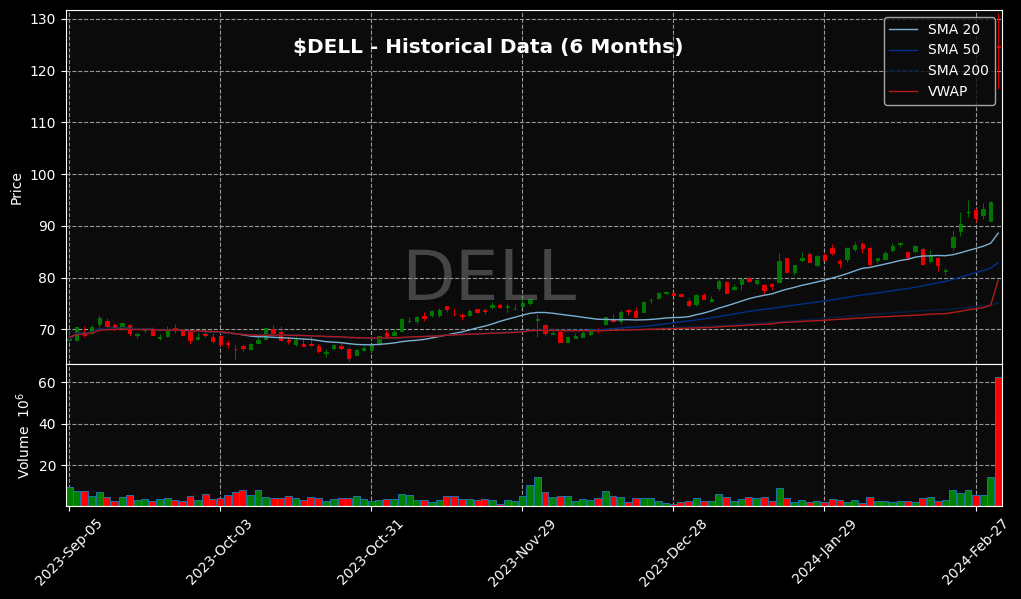

In [ ]:
import mplfinance as mpf
# candlestick chart
# MANDATORY DATA = 'open', 'high', 'low', 'close', 'volume'

"""
Part 1:    
"""
# Part 1a: SMAs -> calculate
dell_df['SMA20'] = dell_df['close'].rolling(window=20, min_periods=1).mean()
dell_df['SMA50'] = dell_df['close'].rolling(window=50, min_periods=1).mean()
dell_df['SMA200'] = dell_df['close'].rolling(window=200, min_periods=1).mean()

# Part 1b: VWAP -> calculate
dell_df['VWAP'] = (dell_df['volume'] * (dell_df['high'] + dell_df['low'] + dell_df['close']) / 3).cumsum() / dell_df['volume'].cumsum()

"""   
Part 2: 
"""
add2plot = [
    #### SMAs ####
    mpf.make_addplot(dell_df['SMA20'], color='#7BAFD4', width=1.0, label='SMA 20'), # UNC blue
    mpf.make_addplot(dell_df['SMA50'], color='#003087', width=1.0, label='SMA 50'), # DUKE blue
    mpf.make_addplot(dell_df['SMA200'], color='#041E42', width=1.0, label='SMA 200'), # HOYAS blue
    #### VWAP ####
    mpf.make_addplot(dell_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP') # BIG RED
]

"""   
Part 3: styling not iterative changes related to data (i.e., color, font, etc.)
"""
# Use a dark theme style and set text color to white
mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})

# Plot the candlestick chart with the moving averages
fig, axes = mpf.plot(dell_df,
                     type='candle',
                     addplot=add2plot,
                     volume=True,
                    #  style=mpf_style,
                     style=s, 
                     # WTF look at docs (it's not erroring out but going to default style just figure out what that is i think)
                     figratio=(15, 8),
                     title='$DELL - Historical Data (6 Months)',
                     tight_layout=True,
                     returnfig=True)

# Add a watermark if needed
fig.text(0.5, 0.5, 'DELL', fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

plt.show()


In [ ]:
dell_df.head(5)

,symbol,close,high,low,open,volume,updated,SMA20,SMA50,SMA200,VWAP
date,,,,,,,,,,,
2023-09-05,DELL,68.10,69.8300,67.54,68.05,9466373.0,1706134856000,68.100000,68.100000,68.100000,68.490000
2023-09-06,DELL,70.47,70.4800,67.83,68.00,7585616.0,1706134852000,69.285000,69.285000,69.285000,68.980820
2023-09-07,DELL,68.98,70.6197,68.57,69.47,7649325.0,1706134857000,69.183333,69.183333,69.183333,69.107501
2023-09-08,DELL,70.50,70.8900,69.09,69.37,5550484.0,1706134855000,69.512500,69.512500,69.512500,69.300610
2023-09-11,DELL,72.16,72.8200,70.56,71.12,7449202.0,1706134853000,70.042000,70.042000,70.042000,69.803676


In [ ]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [ ]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [ ]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [ ]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [ ]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [ ]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [ ]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [ ]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)